# Product Category Classification with DistilBERT
*Fine-tuning a transformer to classify e-commerce product descriptions*

## Import Libraries

Libraries required for data processing and modeling are imported.

This project runs in Google Colab to make use of the free GPU support.
Start by mounting Google Drive to access the project files. If this is your first time running the project, clone the repository. Otherwise, pull the latest changes to stay up to date.
Once that’s done, run the setup script to install any dependencies and make sure the environment is ready to go.

In [1]:
# Mount Drive on colab manually
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# If the repo doesn't exist in Google Drive, clone it
# !git clone https://github.com/herrerovir/Product-category-classifier

# If the repo does exist:
%cd /content/drive/MyDrive/Colab_Projects/Product-category-classifier
!git pull

/content/drive/MyDrive/Colab_Projects/Product-category-classifier
Updating 0af5209..c83913f
error: Your local changes to the following files would be overwritten by merge:
	notebooks/Product-category-classification.ipynb
Please commit your changes or stash them before you merge.
Aborting


In [3]:
# Import colab_up file
import colab_setup
colab_setup.setup(subdir = "notebooks")
from colab_setup import *

Working directory set to: /content/drive/MyDrive/Colab_Projects/Product-category-classifier/notebooks


In [4]:
# Install dependencies
!pip install evaluate

# Utilities
import re
import torch
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Hugging Face Transformers
from transformers import (
    AutoModelForSequenceClassification,
    DistilBertTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TextClassificationPipeline
)
import transformers

# Datasets
from datasets import Dataset, DatasetDict

# Evaluation
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00


## Data Loading

The dataset is loaded from a CSV file into a pandas DataFrame.

In [5]:
data = pd.read_csv(RAW_DIR / "ecomm_data.csv")
data.head()

,Household,"Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room."
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


In [6]:
print(f"Original dataset shape: {data.shape}")

Original dataset shape: (50424, 2)


## Data Cleaning

Cleaning steps include renaming columns for consistency, removing null values, and dropping duplicate rows to ensure data quality before modeling.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### Rename Columns

Column names are updated for clarity and consistency, making the data easier to work with throughout the project.

In [8]:
data.columns

Index(['Household', 'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and s

In [9]:
data = data.rename(columns = {data.columns[0]: "label", data.columns[1]: "product_description"})
data.head()

,label,product_description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


### Null Values

Rows containing null values are removed to maintain data integrity. This helps ensure the dataset is complete and reduces potential issues during analysis and modeling.

In [10]:
data.isna().sum()

,0
label,0
product_description,1


In [11]:
data = data.dropna()

In [12]:
print(f"Missing values are dropped from the dataset. New dataset shape: {data.shape}")

Missing values are dropped from the dataset. New dataset shape: (50423, 2)


### Duplicated Values

Rows that have duplicate values across all columns are identified and removed. This helps prevent redundant data from affecting the analysis and model performance.

In [13]:
full_dupes = data[data.duplicated()]
print(f"Full duplicate rows: {full_dupes.shape[0]}")

Full duplicate rows: 22622


In [14]:
# Show a sample of duplicated rows
full_dupes.head(10)

,label,product_description
6,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
10,Household,Paper Plane Design Starry Night Vangoh Wall Ar...
11,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
15,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
19,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
20,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
21,Household,Incredible Gifts India Wooden Happy Birthday U...
22,Household,Posterhouzz Comics Superhero Thor Joker Black ...
23,Household,Indianara Motivational Square Synthetic Wood A...
26,Household,Painting Mantra Synthetic Wood Art Street Trop...


In [15]:
# Remove duplicates
data = data.drop_duplicates(subset = ["label", "product_description"])
print(f"Dataset shape after dropping duplicates: {data.shape}")

Dataset shape after dropping duplicates: (27801, 2)


### Class Balance

The distribution of class labels is examined to check for balance. Understanding class proportions helps guide modeling decisions and ensures the model performs well across all categories

In [16]:
label_dist = data["label"].value_counts(ascending = True)
label_dist

,count
label,
Electronics,5308
Clothing & Accessories,5674
Books,6256
Household,10563


The dataset includes four product categories with a moderate class imbalance. The "Household" category makes up the largest share, while "Electronics" is the smallest. Although the gap isn’t large, it could impact model performance. It’s a good idea to monitor class-specific metrics during evaluation to ensure the model learns each category fairly.

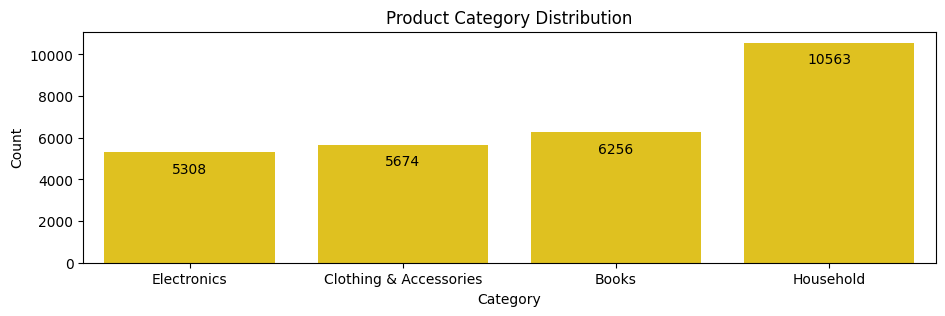

In [17]:
# Plot label counts
plt.figure(figsize = (11, 3))
ax = sns.barplot(x = label_dist.index, y = label_dist.values, color = "gold")

# Add counts on top of bars with formatted numbers
for i, count in enumerate(label_dist.values):
    ax.text(i, count -1000, f"{count}", ha = "center", fontsize = 10)

# Add labels and title
plt.title("Product Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.savefig(FIGURES_DIR / "product-category-distribution.png")

### Label Enconding

Text labels are converted to integer values to make them compatible with the model. This mapping ensures the model can process the target categories effectively.

In [18]:
# Convert textual category labels into integers
label_mapping = {
    "Electronics": 0,
    "Household": 1,
    "Books": 2,
    "Clothing & Accessories": 3
}

data["label"] = data["label"].map(label_mapping)

In [19]:
data.head()

,label,product_description
0,1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,1,SAF 'UV Textured Modern Art Print Framed' Pain...
2,1,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,1,Incredible Gifts India Wooden Happy Birthday U...
4,1,Pitaara Box Romantic Venice Canvas Painting 6m...


### Text Cleaning

Product descriptions are normalized by converting all text to lowercase, removing punctuation, and standardizing whitespace. These steps help reduce noise and improve consistency for better model training.

In [20]:
# Function to normalize and clean the product description text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()                         # Lowercase everything
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special chars
        text = re.sub(r"\s+", " ", text)            # Replace multiple spaces with one
        return text.strip()
    return ""

# Apply text cleaning
data["product_description"] = data["product_description"].apply(clean_text)

In [21]:
data.head()

,label,product_description
0,1,saf floral framed painting wood 30 inch x 10 i...
1,1,saf uv textured modern art print framed painti...
2,1,saf flower print framed painting synthetic 135...
3,1,incredible gifts india wooden happy birthday u...
4,1,pitaara box romantic venice canvas painting 6m...


### Shuffle the Data

The dataset is shuffled to introduce randomness, helping prevent any order-related bias before training begins.

In [22]:
data = shuffle(data, random_state = 42).reset_index(drop = True)

In [23]:
# Save the cleaned dataset
data.to_csv(PROCESSED_DIR / "ecomm_data_cleaned.csv")

## Data Split

The dataset is divided into training and testing sets to evaluate the model’s performance on unseen data. This split helps ensure the model generalizes well beyond the data it was trained on.

In [24]:
# Split data with stratification to keep label distribution balanced
train_df, test_df = train_test_split(
    data,
    test_size = 0.1,
    stratify = data["label"],
    random_state = 42
)

In [25]:
# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop = True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop = True))

## Tokenization

Product descriptions are converted into tokens using a pretrained DistilBert tokenizer. Each text is truncated or padded to a fixed length so the model receives consistent input sizes. The tokenized data is then formatted as PyTorch tensors, keeping only the input IDs, attention masks, and labels needed for training.

In [26]:
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function with truncation and padding
def tokenize_function(examples):
    return tokenizer(examples["product_description"], truncation = True, padding = "max_length", max_length = 128)

# Apply tokenization
train_tokens = train_dataset.map(tokenize_function, batched = True)
test_tokens = test_dataset.map(tokenize_function, batched = True)

# Set format for PyTorch tensors and keep only necessary columns
columns_to_return = ["input_ids", "attention_mask", "label"]
train_tokens.set_format(type = "torch", columns = columns_to_return)
test_tokens.set_format(type = "torch", columns = columns_to_return)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/25020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2781 [00:00<?, ? examples/s]

## Data Collator

This data collator pads input sequences dynamically to match the longest one in each batch. This makes training more efficient compared to padding all inputs to a fixed maximum length.

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)